# Jupyter Notebook: vEMINR Official Tutorial: Inference

### **1. Introduction**

Hello! Welcome to the interactive Jupyter Notebook tutorial for vEMINR.

vEMINR is a fast isotropic reconstruction method based on Implicit Neural Representations (INR), designed specifically for Volume Electron Microscopy (vEM) images. It aims to solve the problem where the axial resolution (Z-axis) of vEM images is significantly lower than the lateral resolution (XY-plane), thereby enabling high-quality 3D reconstruction. Compared to traditional and other deep learning methods, vEMINR shows significant advantages in both reconstruction speed and quality, making it particularly suitable for processing terabyte-scale datasets.

This tutorial will guide you through the following steps:
*   **Model inference**: Do reconstruction using well-trained model


**Core Resources:**
*   **Official Repository**: [https://github.com/KysonYang001/vEMINR](https://github.com/KysonYang001/vEMINR)

In [2]:
import datasets
import os
import argparse
import yaml
from tqdm import tqdm
from models.controller import *
import numpy as np
from skimage import io

### **2. Model Inference**

Once training is complete, or by using a pretrained model provided by the authors, we can proceed with inference. The inference process follows the workflow in Figure 1b of the paper, taking an anisotropic volume as input and reconstructing an isotropic volume.

For demonstration purposes, the inference stage showcases reconstruction from YZ-plane slices. To achieve a more robust and stable reconstruction, we recommend averaging the results obtained from both the XZ and YZ planes

test dataset rank0: size=256


(Z, Y, X): (256, 256, 256)


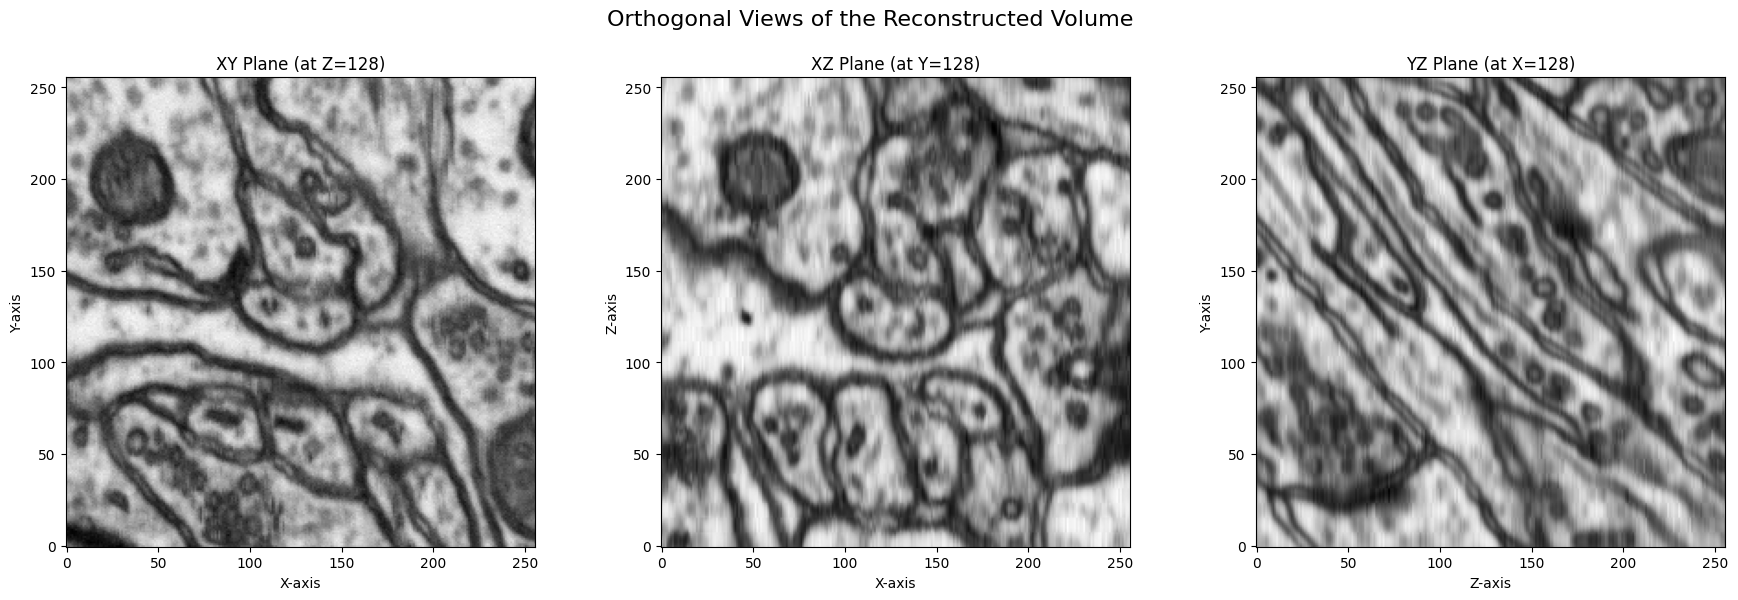

In [3]:
from test import batched_predict
from show_utils import visualize_orthogonal_views
args = argparse.Namespace()
args.model_weight= 'checkpoints/sr/EPFL/epoch-best.pth'
args.save = 'output'
args.test_config = 'configs/test_yz.yaml'



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
with open(args.test_config, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

direct = config['test_dataset']['dataset']['args']['direction']
scale = config['test_dataset']['dataset']['args']['scale']

save_dir = os.path.join(args.save, direct)
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

loader = datasets.make_data_loaders(config, DDP=False, state='test')

if direct not in ['xz', 'yz']:
    raise ValueError('direction should be xz or yz')
model = models.make(config['model'], args={'config': config}, load_sd=args.model_weight).to(device)


bs = config['batch_size']
length = len(loader) * bs

volume = None
idx = 0

for batch in tqdm(loader, leave=False, desc='test'):
    inp, coord, cell, shape = batch['inp'], batch['coord'], batch['cell'], batch['shape']
    inp, coord, cell = inp.to(device), coord.to(device), cell.to(device)
    inp = (inp - 0.5) / 0.5
    h = shape[0][0]
    w = shape[1][0]
    model.eval()
    with torch.no_grad():
        pred = batched_predict(model, inp, coord, cell, bsize=30000)

    pred = pred * 0.5 + 0.5
    pred = pred.detach().view(-1, h, w).cpu().numpy()  # [batch, h, w]

    for i in range(pred.shape[0]):
        img_array = np.clip(pred[i] * 255, 0, 255).astype(np.uint8)
        io.imsave(f'{args.save}/{direct}/{idx}.png', img_array)

        if volume is None:
            if direct == 'yz':
                volume = np.zeros((h, w, length), dtype=np.uint8)
            else:
                volume = np.zeros((h, length, w), dtype=np.uint8)

        if direct == 'yz':
            volume[:, :, idx] = img_array.reshape(h, w)
        else:
            volume[:, idx, :] = img_array.reshape(h, w)

        idx += 1
if direct == 'yz':
    volume = volume[:, :, :idx]
else:
    volume = volume[:, :idx, :]


io.imsave(f'{args.save}/{direct}.tif', volume)
visualize_orthogonal_views(volume)